<a href="https://colab.research.google.com/github/cyruskimani/Divvy/blob/main/Copy_of_Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis Questions
1. Is efficiency higher in the Equal Rationing treatment than in the Proportional Rationing treatment.

2. How does efficiency vary with Group. Is there an interaction with the
treatment?

3. How does the first-stage allowance auction price differ by group/treatment?
Is there an interaction effect?

4. How does overbuying differ by group/treatment? Is there an interaction effect?

5. Is there a difference in first-stage auction participation by treatment?

6. Do any differences between group/treatment persist throughout the
length of the experiment?

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

## Round Data.

### Round data column descriptions.

In [7]:
round_data_descriptions = pd.read_csv('/content/drive/MyDrive/25052021/round_data_column_desc.csv')
round_data_descriptions

,treatment,"""Proportional"" or ""Equal"" for reserve auction mechanism"
0,group,"""High"" or ""Low"" for whether it was group with..."
1,experiment_id,unique id for each group
2,round,which of 32 auctions
3,auction_price,the price in the first-stage uniform price au...
4,total_demand,the total quantity demanded in the system
5,total_auction_income,auction_price * number of units sold in the a...
6,tier_1_income,number of units sold in the 1st tier * 20
7,tier_2_income,number of units sold in the 2nd tier * 30
8,efficiency,Dependent on the demand profile. efficiency=...
9,demand_profile,there were 8 unique demand curves (value + qu...


### Loading the Data.

In [14]:
# Loading the data.
r_df = pd.read_csv('/content/drive/MyDrive/25052021/round_data.csv')
r_df.head()

,treatment,group,experiment_id,round,auction_price,total_demand,total_auction_income,tier_1_income,tier_2_income,efficiency,demand_profile,overbuying_count,efficiency_relative,high_value_demand,demand_level
0,Proportional,High,0,1,20,168,1200,1000,900,0.840265,5,0,-0.201721,0,2
1,Proportional,High,0,2,30,151,1800,1000,1020,0.870866,3,1,-0.416870,0,1
2,Proportional,High,0,3,50,151,3000,1000,1170,0.938058,3,1,0.320363,0,1
3,Proportional,High,0,4,40,210,2400,1000,1500,0.786597,6,0,0.366418,1,3
4,Proportional,High,0,5,45,210,2700,1000,1500,0.791824,7,0,0.118316,0,3


In [10]:
# Checking for null values.
r_df.isna().sum()

treatment               0
group                   0
experiment_id           0
round                   0
auction_price           0
total_demand            0
total_auction_income    0
tier_1_income           0
tier_2_income           0
efficiency              0
demand_profile          0
overbuying_count        0
efficiency_relative     0
high_value_demand       0
demand_level            0
dtype: int64

* No null values were found.

In [12]:

# Checking for duplicates
r_df.duplicated().sum()

0

* No duplicates were found.

## Subject Data.

In [8]:
subject_data_description = pd.read_csv('/content/drive/MyDrive/25052021/subject_data_column_desc.csv')
subject_data_description

,treatment,"""Proportional"" or ""Equal"" for reserve auction mechanism"
0,group,"""High"" or ""Low"" for whether it was group with..."
1,round,which of the 32 auctions
2,subject_id,unique id for each subject
3,experiment_id,unique id for each group
4,demand_profile,there were 8 unique demand curves (value + qu...
5,high_value_demand,whether the demand profile is one in which bi...
6,demand_level,the level of demand in the profile. Index ve...
7,value,this subject's value this round
8,demand,this subject's total demand for this round
9,auction_bid_price,subject's price bid in the first-stage auction


### Loading the data.

In [13]:
s_df = pd.read_csv('/content/drive/MyDrive/25052021/subject_data.csv')
s_df.head()

,treatment,group,round,subject_id,experiment_id,demand_profile,high_value_demand,demand_level,value,demand,auction_bid_price,auction_bid_quantity,auction_price,auction_received,tier_1_demanded,tier_2_demanded,equal_demanded,tier_1_received,tier_2_received,total_earnings,total_received,overbought
0,Proportional,High,1,0,0,5,0,2,85,17,50,10,20,10,3,2,0,1,2,825,13,0
1,Proportional,High,2,0,0,3,0,1,75,18,65,10,30,10,4,3,0,2,3,695,15,0
2,Proportional,High,3,0,0,3,0,1,55,22,50,15,50,15,4,3,0,2,3,220,20,0
3,Proportional,High,4,0,0,6,1,3,55,21,45,10,40,10,6,4,0,5,3,400,18,0
4,Proportional,High,5,0,0,7,0,3,65,28,45,15,45,15,7,5,0,4,4,620,23,0


In [15]:
# Checking for null values
s_df.isna().sum()

treatment               0
group                   0
round                   0
subject_id              0
experiment_id           0
demand_profile          0
high_value_demand       0
demand_level            0
value                   0
demand                  0
auction_bid_price       0
auction_bid_quantity    0
auction_price           0
auction_received        0
tier_1_demanded         0
tier_2_demanded         0
equal_demanded          0
tier_1_received         0
tier_2_received         0
total_earnings          0
total_received          0
overbought              0
dtype: int64

* No null values

In [16]:
# Checking for duplicates
s_df.duplicated().sum()

0

* No duplicates were found.

## Importing Pymc3.

In [ ]:
!pip install pymc3

In [28]:
import pymc3 as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

### Instantiating the model.

In [32]:
# Finding the  maximum of efficiency
column = r_df["efficiency"]
max_value = column.max()
print(max_value)

1.0


In [33]:
# Finding the  minimum of efficiency
column = r_df["efficiency"]
min_value = column.min()
print(min_value)

0.6439159975293391


In [34]:
# Standard deviation of efficiency
r_df['efficiency'].std()

0.08772730249199161

In [35]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0.6439159975293391, upper=1.0)  # Range of Efficiency
    σ = pm.HalfNormal('σ', sd=0.08772730249199161)            # Standard deviation of efficiency
    y = pm.Normal('y', mu=μ, sd=σ, observed=r_df['efficiency'].values)
    trace_g = pm.sample(1000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


### Fitting the model.

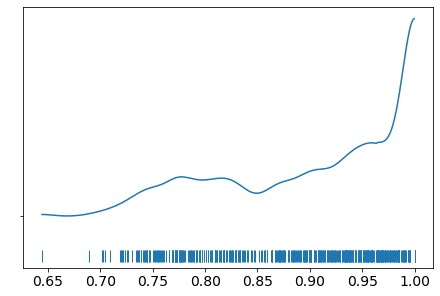

In [29]:
az.plot_kde(r_df['efficiency'].values, rug=True)
plt.yticks([0], alpha=0);

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


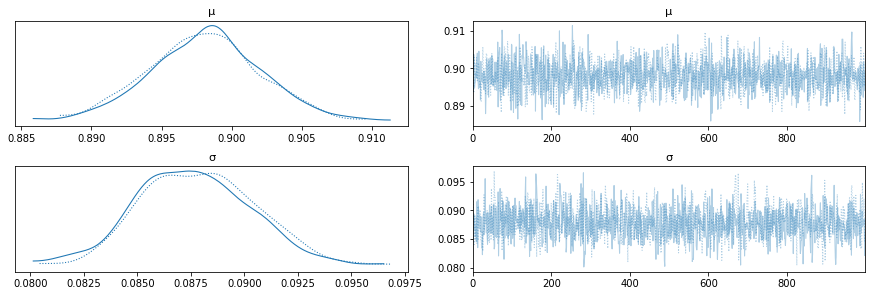

In [36]:
# Plotting the gausian model trace.
az.plot_trace(trace_g);

/usr/local/lib/python3.7/dist-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/utils.py:409: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cov" failed type inference due to: Untyped global name '_dot': cannot determine Numba type of <class 'arviz.utils.maybe_numba_fn'>

File "../usr/local/lib/python3.7/dist-packages/arviz/utils.py", line 421:
def _cov(data):
    <source elided>
        x -= avg[:, None]
        prod = _dot(x

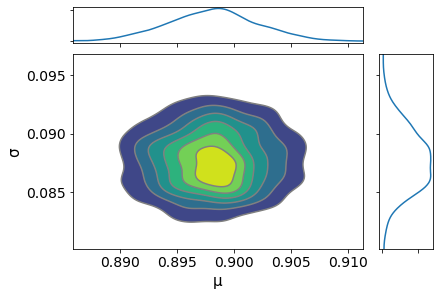

In [37]:
# Plotting joint distribution of parameters
az.plot_joint(trace_g, kind='kde', fill_last=False);

In [38]:
# Detailed summary of the posterior distribution for each parameter.
az.summary(trace_g)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.898,0.004,0.891,0.906,0.0,0.0,1742.0,1452.0,1.0
σ,0.088,0.003,0.083,0.093,0.0,0.0,1600.0,1214.0,1.0


Q1. Is efficiency higher in the Equal Rationing treatment than in the Proportional Rationing treatment?

In [19]:
r_df['treatment'].unique()

array(['Proportional', 'Equal'], dtype=object)

In [20]:
r_df.head()

,treatment,group,experiment_id,round,auction_price,total_demand,total_auction_income,tier_1_income,tier_2_income,efficiency,demand_profile,overbuying_count,efficiency_relative,high_value_demand,demand_level
0,Proportional,High,0,1,20,168,1200,1000,900,0.840265,5,0,-0.201721,0,2
1,Proportional,High,0,2,30,151,1800,1000,1020,0.870866,3,1,-0.416870,0,1
2,Proportional,High,0,3,50,151,3000,1000,1170,0.938058,3,1,0.320363,0,1
3,Proportional,High,0,4,40,210,2400,1000,1500,0.786597,6,0,0.366418,1,3
4,Proportional,High,0,5,45,210,2700,1000,1500,0.791824,7,0,0.118316,0,3


In [ ]:
jupyter nbconvert --to html notebook.ipynb  